Lets see if what we found for the posteriors derived from compressed data is the same for Fisher forecasts using the same toy example as `toy_pca.ipynb`.

In [1]:
import emcee
import numpy as np 
import corner as DFM
# --- emanu---
from emanu import compressor as Comp
from emanu import forecast as Forecast

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Lets set up the same toy example as `toy_pca.ipynb` --- model is a line and data has some white uncorelated noise.

In [3]:
theta_true = np.array([0.5, 0.5])
cov_true = np.identity(20)
def model(theta): 
    return theta[0] * np.arange(20) + theta[1]
X_true = model(theta_true)

In [4]:
X_data = np.random.multivariate_normal(model(theta_true), cov_true, size=10000)
cov_data = np.cov(X_data.T)

cinv_data = np.linalg.inv(cov_data)

nmock, ndata = X_data.shape
cinv_data *= float(nmock - ndata - 2)/float(nmock - 1) 

(0.0, 19.0)

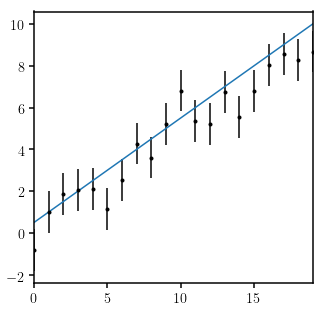

In [5]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.errorbar(range(len(X_true)), X_data[0], np.sqrt(np.diag(cov_true)), fmt='.k')
sub.plot(model(theta_true))
sub.set_xlim(0., 19.)

Now lets train the different PCA compression methods with different number of components

In [6]:
cmpsr0 = Comp.Compressor(method='PCA')      
cmpsr0.fit(X_data, n_components=20, whiten=False)

cmpsr1 = Comp.Compressor(method='PCA')      
cmpsr1.fit(X_data, n_components=10, whiten=False)

cmpsr2 = Comp.Compressor(method='PCA')      
cmpsr2.fit(X_data, n_components=5, whiten=False)

In [7]:
c0X_true = cmpsr0.transform(np.atleast_2d(model(theta_true)))
c1X_true = cmpsr1.transform(np.atleast_2d(model(theta_true)))
c2X_true = cmpsr2.transform(np.atleast_2d(model(theta_true)))

c0X_data = cmpsr0.transform(X_data)
c1X_data = cmpsr1.transform(X_data)
c2X_data = cmpsr2.transform(X_data)

c0cov_data = np.cov(c0X_data.T)
c1cov_data = np.cov(c1X_data.T)
c2cov_data = np.cov(c2X_data.T)

c0cinv_data = np.linalg.inv(c0cov_data) * float(c0X_data.shape[0] - c0X_data.shape[1] - 2)/float(c0X_data.shape[0] - 1) 
c1cinv_data = np.linalg.inv(c1cov_data) * float(c1X_data.shape[0] - c1X_data.shape[1] - 2)/float(c1X_data.shape[0] - 1) 
c2cinv_data = np.linalg.inv(c2cov_data) * float(c2X_data.shape[0] - c2X_data.shape[1] - 2)/float(c2X_data.shape[0] - 1) 

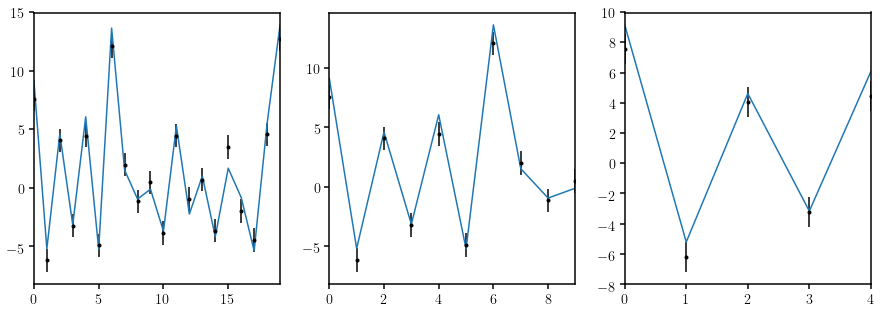

In [8]:
fig = plt.figure(figsize=(15,5))
for i, cX_data, cX_true, ccov_data in zip(range(3), [c0X_data, c1X_data, c2X_data], [c0X_true, c1X_true, c2X_true], [c0cov_data, c1cov_data, c2cov_data]): 
    sub = fig.add_subplot(1,3,i+1)
    sub.errorbar(range(cX_data.shape[1]), cX_data[0], np.sqrt(np.diag(ccov_data)), fmt='.k')
    sub.plot(cX_true.flatten(), c='C0')
    sub.set_xlim(0., cX_data.shape[1]-1)

Before we calculate the Fisher matrices, lets get the true posterior from MCMC

running burn-in chain
running main chain


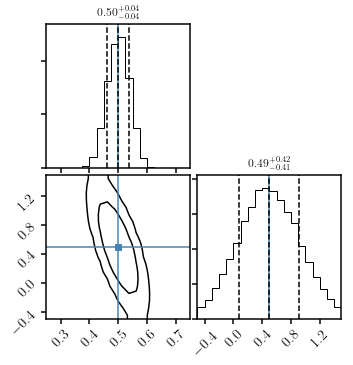

In [9]:
# initialize walkers randomly drawn from prior 
ndim = len(theta_true)

prior_range = np.array([[0.25, 0.75], [-0.5, 1.5]])

def lnprior(tt): 
    ''' log uniform prior. totally uninformative
    '''
    t0, t1 = tt 
    if (prior_range[0][0] <= t0 <= prior_range[0][1]) and (prior_range[1][0] <= t1 <= prior_range[1][1]):
        return 0.0 
    return -np.inf 

def lnlike(tt): 
    ''' log likelihood of the full data
    '''
    delta = (model(tt) - X_true) 
    return -0.5*np.dot(delta, np.dot(cinv_data, delta.T))

def lnprob(tt):
    lp = lnprior(tt)
    if not np.isfinite(lp): 
        return -np.inf 
    return lp + lnlike(tt)

nwalkers=100
burn_in_chain=200
main_chain=1000 

pos = [np.random.uniform(prior_range[:,0], prior_range[:,1]) for i in range(nwalkers)]

# run mcmc 
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print('running burn-in chain') 
pos, prob, state = sampler.run_mcmc(pos, burn_in_chain)
sampler.reset()
print('running main chain') 
sampler.run_mcmc(pos, main_chain)

# save chain 
post = sampler.flatchain.copy() 

fig = DFM.corner(post, color='k', quantiles=[0.16, 0.5, 0.84], levels=[0.68, 0.95], 
                 bins=20, range=prior_range, truths=theta_true,
                 smooth=True, show_titles=True, 
                 plot_datapoints=False, plot_density=False, label_kwargs={'fontsize': 20}) 

In [11]:
#true 1-sigma values
q00, q01, q02 = np.quantile(post[:,0], [0.16, 0.5, 0.84])
q10, q11, q12 = np.quantile(post[:,1], [0.16, 0.5, 0.84])
print q01-q00, q11-q10

0.03930122726727303 0.41164133288926685


Now lets calculate the Fisher matrices. First lets derive the Fisher forecasts for the full data --- _i.e._ the "true" Fisher. 

In [12]:
# derivatives
dXdts = []
for i in range(len(theta_true)): 
    theta_m = theta_true.copy() 
    theta_m[i] -= 0.1
    X_m = model(theta_m)
    
    theta_p = theta_true.copy()
    theta_p[i] += 0.1
    X_p = model(theta_p)
    
    dXdt = (X_p - X_m)/0.2
    dXdts.append(dXdt)

In [13]:
Fij = Forecast.Fij(dXdts, cinv_data) # fisher 
Finv = np.linalg.inv(Fij)

In [14]:
# Fisher "true" 1-sigma values
print np.sqrt(np.diag(Finv))

[0.03904525 0.43267097]


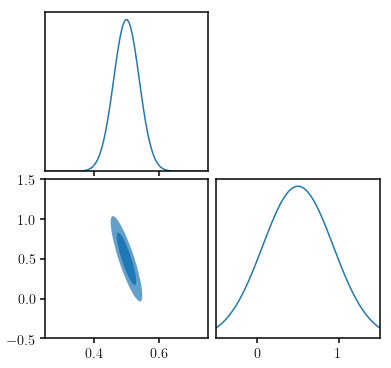

In [15]:
fig = Forecast.plotFisher([Finv], theta_true, ranges=prior_range)

The marginalized constraints are close enough to the true MCMC posteriors. Now lets see how well the compressed Fisher look like!

In [17]:
dc0Xdts = cmpsr0.transform(dXdts)
dc1Xdts = cmpsr1.transform(dXdts)
dc2Xdts = cmpsr2.transform(dXdts)

c0Fij = Forecast.Fij(dc0Xdts, c0cinv_data) # fisher 
c1Fij = Forecast.Fij(dc1Xdts, c1cinv_data) # fisher 
c2Fij = Forecast.Fij(dc2Xdts, c2cinv_data) # fisher 

c0Finv = np.linalg.inv(c0Fij)
c1Finv = np.linalg.inv(c1Fij)
c2Finv = np.linalg.inv(c2Fij)

In [18]:
print np.sqrt(np.diag(c0Finv))
print np.sqrt(np.diag(c1Finv))
print np.sqrt(np.diag(c2Finv))

[0.03904525 0.43267097]
[0.06168335 0.7554018 ]
[0.07837917 1.04434469]


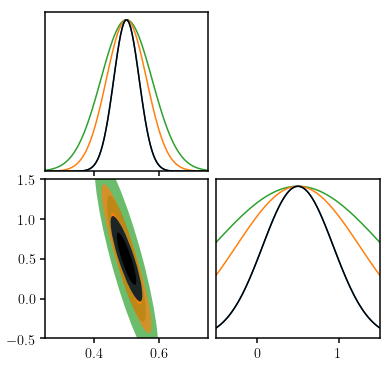

In [21]:
fig = Forecast.plotFisher([c2Finv, c1Finv, c0Finv, Finv], theta_true, ranges=prior_range, colors=['C2', 'C1', 'C0', 'k'])

As expected, the forecasts are broader when we use fewer components. The fewer components we use the more information we throw out. Also as expected, when we use the original data dimensions as the number of components, we recover the "true" Fisher. 